# VGG
使用卷积神经网络搭建VGG网络来对Fasion MNIST数据集进行训练。

## 1 加载相关库

In [1]:
import torch
import torchvision
from torch import nn
from IPython import display
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

## 2 搭建模型

### 2.1 构造VGG块

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                                kernel_size = 3, padding = 1, stride = 1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))
    
    return nn.Sequential(*layers)

### 2.2 搭建VGG网络

In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for num_convs, out_channels in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*conv_blks, nn.Flatten(), 
                          #全连接层部分
                           nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU (),
                           nn.Dropout(p = 0.5),
                           nn.Linear(4096, 4096), nn.ReLU (),
                           nn.Dropout(p = 0.5),
                           nn.Linear(4096, 10))

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

In [5]:
X = torch.randn(size=(1, 1, 224, 224))
for block in net:
    X = block(X)
    print(block.__class__.__name__, "out shape:\t\t", X.shape)

Sequential out shape:		 torch.Size([1, 64, 112, 112])
Sequential out shape:		 torch.Size([1, 128, 56, 56])
Sequential out shape:		 torch.Size([1, 256, 28, 28])
Sequential out shape:		 torch.Size([1, 512, 14, 14])
Sequential out shape:		 torch.Size([1, 512, 7, 7])
Flatten out shape:		 torch.Size([1, 25088])
Linear out shape:		 torch.Size([1, 4096])
ReLU out shape:		 torch.Size([1, 4096])
Dropout out shape:		 torch.Size([1, 4096])
Linear out shape:		 torch.Size([1, 4096])
ReLU out shape:		 torch.Size([1, 4096])
Dropout out shape:		 torch.Size([1, 4096])
Linear out shape:		 torch.Size([1, 10])


## 3 动态绘图

In [6]:
def plot_image(num, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc):
    plt.figure(num = num)
    plt.ion()
    plt.cla()
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.plot(range(i + 1), val_loss_his, label='val_loss')
    ax1.grid()
    ax1.legend()
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    ax2.set_xlim(0, num_epochs)
    ax2.set_ylim(0, 1)
    ax2.plot(range(i + 1), train_his_acc, label='train_accuracy')
    ax2.plot(range(i + 1), val_his_acc, label='val_accuracy')
    ax2.grid()
    ax2.legend()
    display.clear_output(wait=True)
    plt.pause(0.0000001)
    plt.ioff()
    plt.show()

## 4 训练模型

### 4.1 更改图片大小
- 因为AlexNet网络输入是224大小。

In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize([224, 224])])
mnist_train = torchvision.datasets.FashionMNIST(root = "C:/Users/CCU6/Practice/pytorch/data", train = True,
                                                transform = trans, download = True)
mnist_test = torchvision.datasets.FashionMNIST(root = "C:/Users/CCU6/Practice/pytorch/data", train = False,
                                                transform = trans, download = True)

### 4.2 将网络参数用xavier初始化

In [8]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

### 4.3 训练函数
- 这里面使用了小批量梯度下降，如果不用批量梯度下降的话（其他参数不变），网络就会不收敛，准确率一直在0.1附近。

In [9]:
def train_model(net, num_epochs, alpha, device, batch_size):
    #定义的东西
    train_loss_his = []
    val_loss_his = []
    train_his_acc = []
    val_his_acc = []
    train_data_batch = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 0)
    val_data_batch = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = True, num_workers = 0)
    #正式代码
    net.apply(init_weight)
    print(f"train on:{device}")
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = alpha)
    loss = nn.CrossEntropyLoss(reduction='none')
    for i in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        net.train()
        #每次迭代用batch_size大小的数据集进行训练，一轮共every_num_epoch此迭代。
        for k, (data_train, label_train) in enumerate(train_data_batch):
            data_train_k = data_train.to(device)
            label_train_k = label_train.to(device)
            optimizer.zero_grad()
            y_trian_hat = net(data_train_k)
            l_train = loss(y_trian_hat, label_train_k)
            l_train.mean().backward()
            optimizer.step()
            with torch.no_grad():
                train_max_hat = torch.argmax(y_trian_hat, dim = 1)
                train_acc_k = sum(train_max_hat == label_train_k)
                train_acc += train_acc_k
                train_loss += l_train.sum()
        
        net.eval()
        with torch.no_grad():
            val_loss = 0.
            val_acc = 0.
            #验证集的预测
            for data_val, label_val in val_data_batch:
                data_val_k = data_val.to(device)
                label_val_k = label_val.to(device)
                y_val_hat = net(data_val_k)
                val_max_hat = torch.argmax(y_val_hat, dim = 1)
                val_acc_k = sum(val_max_hat == label_val_k)
                l_val = loss(y_val_hat, label_val_k)
                val_acc += val_acc_k
                val_loss += l_val.sum()
            
            train_loss_his.append(((train_loss * 1.0)/len(mnist_train)).cpu())
            val_loss_his.append(((val_loss * 1.0)/len(mnist_test)).cpu())
            train_his_acc.append(((train_acc * 1.0)/len(mnist_train)).cpu())
            val_his_acc.append(((val_acc * 1.0)/len(mnist_test)).cpu())
        #画出每次迭代的图
        plot_image(2, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc)
    print(f"train acc:{max(train_his_acc)}, test acc:{max(val_his_acc)}")
    
    return train_loss_his, val_loss_his, train_his_acc, val_his_acc

In [10]:
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 10, 0.04, 256

In [11]:
ratio = 4
small_conv_arch = [[pair[0], pair[1] // ratio] for pair in conv_arch]
net = vgg(small_conv_arch)

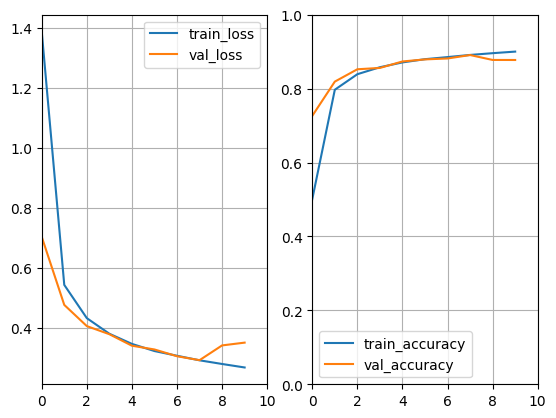

train acc:0.9000833630561829, test acc:0.8907999992370605


In [12]:
train_loss_his, test_loss_his, train_his_acc, test_his_acc = train_model(net, num_epochs, alpha, device, batch_size)